In [84]:
# Imports
import pandas as pd
%matplotlib inline
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import random
import re
import operator
import numpy as np

# Negeren copy warning
pd.options.mode.chained_assignment = None

#Data bron: https://www.kaggle.com/datasnaek/youtube-new/data

In [85]:
# Zet alle data van een csv bestand, naar een DataFrame.
trending_US = pd.DataFrame.from_csv('USvideos_1.csv')
trending_UK = pd.DataFrame.from_csv("GBvideos.csv")
trending_CA = pd.DataFrame.from_csv("CAvideos.csv")

# Verander de categorie ID's in categorietitels.
categories = pd.DataFrame.from_csv("categories.csv",index_col=None)
trending_US= trending_US.merge(categories,on="category_id")
trending_UK = trending_UK.merge(categories,on="category_id")
trending_CA = trending_CA.merge(categories,on="category_id")

In [86]:
# Voeg like en dislike ratios toe
trending_UK['like_view_ratio'] = trending_UK.likes / trending_UK.views
trending_UK['dislike_view_ratio'] = trending_UK.dislikes / trending_UK.views
trending_UK["like_dislike_ratio"] = trending_UK.likes / trending_UK.dislikes

In [87]:
# regelt timecodes
# Tijden moeten ingedeeld worden in blokken van een uur dus 23:30 gaat in het blok van 00:00 en 04:45 in 05:00
times = [[int(y[0]),int(y[1])] for y in [x.split("T")[1][:-8].split(":") for x in trending_UK.publish_time]]
timecodes = [] 
for hour, minutes in times:
    if minutes==0:
        timecodes.append(hour)
    else:
        if hour != 23:
            timecodes.append(hour+1)
        else:
            timecodes.append(0)
trending_UK["timecode"]= pd.Series(timecodes,index=trending_UK.index)

In [88]:
publish_dates = []
for x in trending_UK.publish_time:
    temp = x.split("T")[0].replace("-",".")
    publish_dates.append( temp[2:5]+str(int(temp[-2:])+1)+temp[-6:-3])
trending_UK["publish_date"]=publish_dates


In [89]:
# Berekent de tijd voordat een video trending wordt.
originalTimes = trending_UK[["trending_date","publish_date","timecode"]]
time_until_trending= []
for x in originalTimes.iterrows():
    trendDate = x[1][0].split(".")
    publDate  = x[1][1].split(".")
    timeCode  = int(x[1][2])
    hours  = abs(int(trendDate[1])-int(publDate[1]))*24
    months = abs(int(trendDate[2])-int(publDate[2]))*720
    total = timeCode+hours+months
    time_until_trending.append(total)
trending_UK["time_until_trending"]=time_until_trending

In [90]:
# Dit zijn functies om kleur te bepalen voor de wordclouds.
def color_func_red(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 50%%, %d%%)" % random.randint(40, 80)

def color_func_green(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(40, 80)

def color_func_blue(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 50%%, %d%%)" % random.randint(40, 80)

In [91]:
# Functie om een wordcloud te genereren
def gen_word_cloud(data, color, collo, swords=stopwords.words('english')):
    
    # Kleuren bepalen
    if color == 1:
        func = color_func_red
    elif color == 2:
        func = color_func_green
    else:
        func = color_func_blue
    
    text = " ".join([re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"]", "", str(x).lower()) for x in data])

    wordcloud = WordCloud(width=2000, height=1000, relative_scaling = 1, max_words=40, collocations=collo, regexp=r"\w[\S']+",
                          stopwords = swords # set or space-separated string
                          ).generate(text)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud.recolor(color_func=func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [111]:
def stripTitle(titles,country, stopwords):
    result= []
    stop = stopwords
    for x in titles:
        temp = re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"\|\/\*\?\&]", "", str(x).lower())
        temp = re.sub(r" {2,}", " ", temp)
        
        for y in temp.split(" "):
            if y not in stop and re.fullmatch(r"\D+",y):
                result.append(y)
    return result

def stripTitlesToDict(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)            
    words = pd.DataFrame.from_dict(resultDict,orient='index')
    words.columns=[country]
    words[country]=words[country]/sum(words[country])*100
    return words

def stripTitlesCount(titles,country, stopwords=stopwords.words("english")):
    result= stripTitle(titles,country, stopwords)
    resultDict=Counter(result)
    return resultDict
    

# Hieronder alle tijdelijk uitgecommente code, ivm errors of work in progress

#preparation results code, still needs to be recreated
results=[]
for x in trending.title:
    temp= trending[trending.title==x]
    if len(temp)!=1:
        results.append((max(temp.views)-min(temp.views)/len(temp)))
    else:
        results.append(temp.views.max())
trending["increase_views"]=results

## 1. Welke termen zijn het meest voorkomend in titels van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?

#### 1.1 Overwegend negatieve videos aan de hand van enkele woorden.

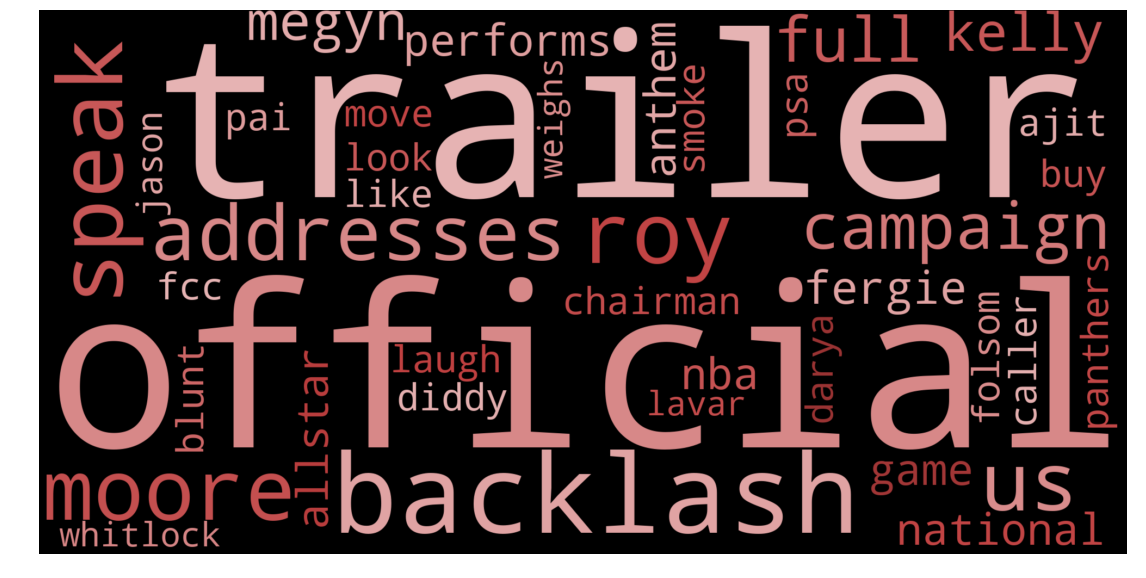

In [93]:
contro = trending_UK[trending_UK.like_dislike_ratio <= 1].title.values
gen_word_cloud(contro, 1, False)

#### 1.2 Overwegend positieve videos aan de hand van enkele woorden.

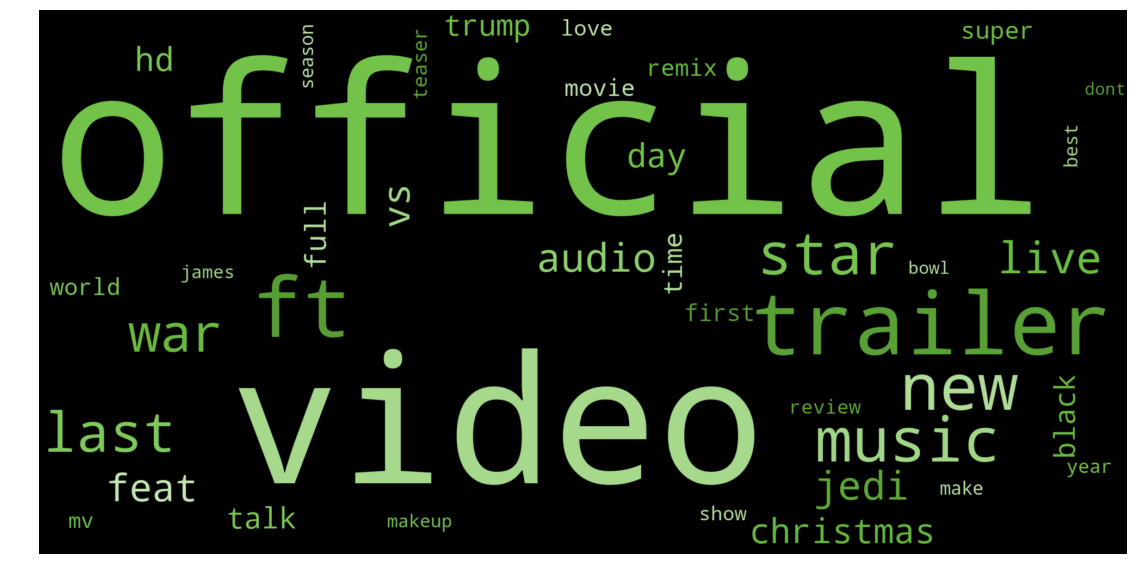

In [94]:
titles = trending_UK[trending_UK.like_dislike_ratio > 1].title.values
gen_word_cloud(titles, 2, False)

In [95]:
titles = stripTitlesCount(trending_UK.title.values, "UK")
titleslike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio > 1].title.values, "UK")
titlesdislike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio <= 1].title.values, "UK")

alles = sorted(titles.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(titleslike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(titlesdislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20], "\n")
print(like[:20], "\n")
print(dislike[:20])

[('official', 3063), ('video', 2595), ('trailer', 1209), ('ft', 1196), ('music', 891), ('new', 842), ('last', 838), ('star', 779), ('wars', 695), ('live', 620), ('jedi', 617), ('audio', 580), ('vs', 565), ('feat', 562), ('christmas', 515), ('mv', 499), ('hd', 487), ('full', 451), ('black', 418), ('day', 414)] 

[('official', 3005), ('video', 2570), ('ft', 1196), ('trailer', 1162), ('music', 891), ('new', 828), ('last', 822), ('star', 758), ('wars', 674), ('live', 620), ('jedi', 601), ('audio', 580), ('feat', 560), ('vs', 555), ('christmas', 506), ('mv', 499), ('hd', 483), ('full', 423), ('black', 418), ('x', 414)] 

[('official', 51), ('trailer', 45), ('backlash', 43), ('roy', 33), ('moore', 33), ('us', 32), ('addresses', 30), ('campaign', 29), ('full', 28), ('megyn', 26), ('kelly', 26), ('fergie', 22), ('performs', 22), ('national', 22), ('anthem', 22), ('nba', 22), ('allstar', 22), ('game', 22), ('psa', 19), ('chairman', 19)]


## 2. Welke termen zijn het meest voorkomend in beschrijvingen en tags van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?


#### 2.1 Alle beschrijvingen aan de hand van enkele woorden met gefilterde stopwoorden

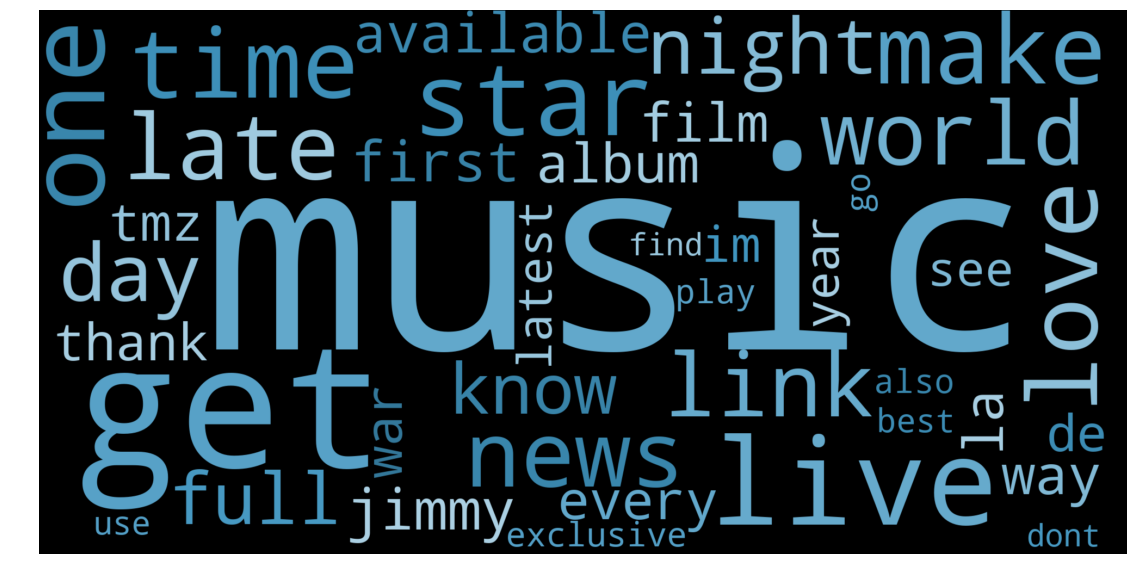

In [96]:
description = trending_UK.description.values
stopwoorden = ['subscribe', 'video', 'facebook', 'twitter', 'instagram', 'youtube', 'videos', 'channel', 'watch', 'like', 'new',
              'us', 'free', 'official', 'episode', 'website', 'show', 'movie']
gen_word_cloud(description, 3, False, stopwoorden + stopwords.words('english'))

#### 2.2 Alle beschrijvingen aan de hand van biagrams

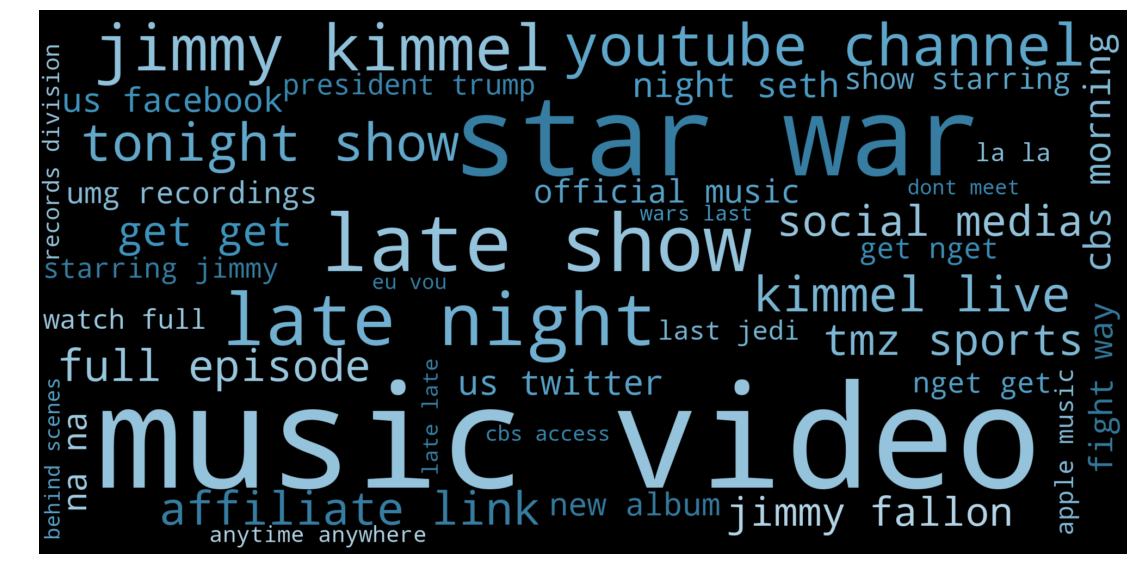

In [97]:
gen_word_cloud(description, 3, True)

#### 2.3 Alle tags aan de hand van biagrams met stopwoorden gefilterd

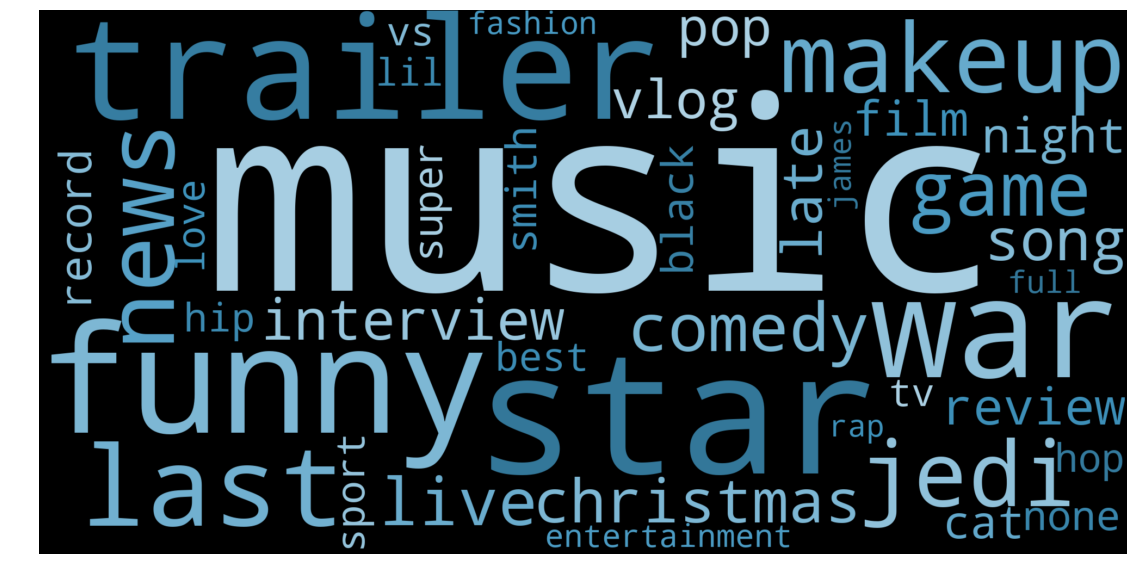

In [98]:
tags = [tag for row in trending_UK.tags.str.split('|') for tag in row]
gen_word_cloud(tags, 3, False, stopwoorden + stopwords.words('english'))

In [113]:
descriptions = stripTitlesCount(description, "UK", stopwoorden + stopwords.words('english'))
descriptionlike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio > 1].description.values, "UK", stopwoorden + stopwords.words('english'))
descriptiondislike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio <= 1].description.values, "UK", stopwoorden + stopwords.words('english'))

alles = sorted(descriptions.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(descriptionlike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(descriptiondislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20], '\n')
print(like[:20], '\n')
print(dislike[:20])

[('music', 8117), ('get', 5656), ('_', 4635), ('live', 3817), ('one', 3328), ('news', 3098), ('late', 3048), ('–', 2971), ('love', 2851), ('world', 2832), ('time', 2778), ('make', 2634), ('star', 2613), ('full', 2474), ('►', 2429), ('first', 2388), ('night', 2371), ('know', 2359), ('available', 2331), ('every', 2281)] 

[('music', 8115), ('get', 5610), ('_', 4635), ('live', 3754), ('one', 3317), ('late', 3048), ('–', 2971), ('love', 2819), ('world', 2808), ('time', 2735), ('news', 2734), ('make', 2597), ('star', 2594), ('full', 2433), ('►', 2416), ('first', 2370), ('night', 2350), ('know', 2339), ('available', 2329), ('links', 2260)] 

[('news', 364), ('cbs', 221), ('morning', 166), ('today', 156), ('nbc', 150), ('jason', 144), ('use', 138), ('latest', 112), ('need', 96), ('ad', 90), ('colin', 90), ('whitlock', 72), ('cowherd', 72), ('mcintyre', 72), ('kelly', 70), ('day', 70), ('speak', 67), ('copyright', 66), ('live', 63), ('council', 63)]


## 3. Is er een verband tussen de ratio van het aantal likes en het aantal views?


[]

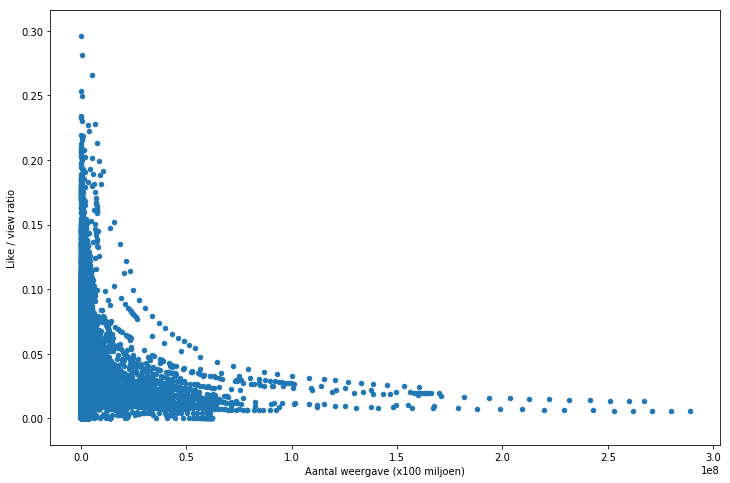

In [100]:
# Ratio likes ten opzichte van views.
trending_UK.sort_values(by='views').plot(x='views', y="like_view_ratio", figsize=(12,8), kind="scatter", title="")
plt.xlabel('Aantal weergave (x100 miljoen)')
plt.ylabel('Like / view ratio')
plt.plot()

## 4. Is er een verband tussen de ratio van het aantal dislikes en het aantal views?


[]

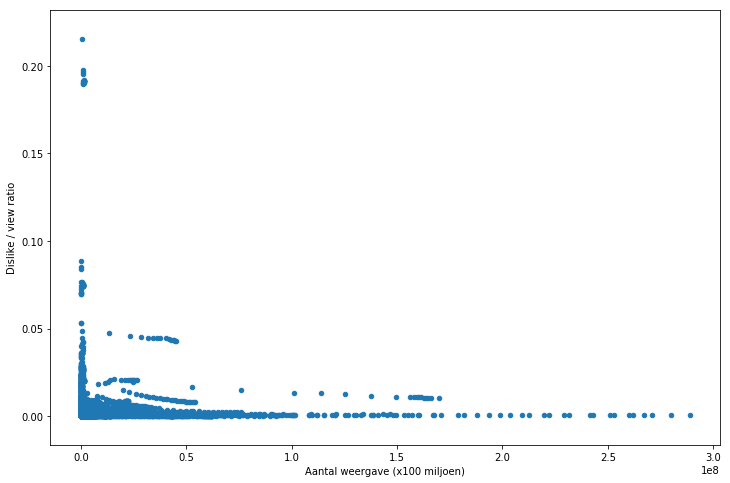

In [101]:
# Ratio dislikes ten opzichte van views.
trending_UK.sort_values(by='views').plot(x='views', y="dislike_view_ratio", figsize=(12,8), kind='scatter')
plt.xlabel('Aantal weergave (x100 miljoen)')
plt.ylabel('Dislike / view ratio')
plt.plot()

## 5. Zijn er verschillen in titels tussen US, GB en CA?

[]

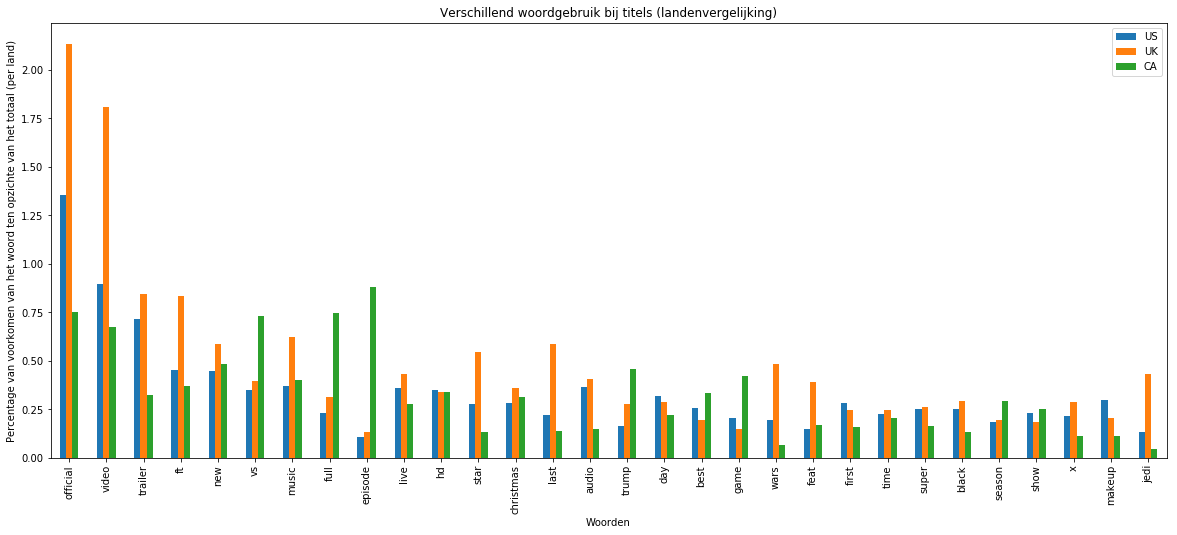

In [102]:

US=stripTitlesToDict(trending_US.title.values,"US")
CA=stripTitlesToDict(trending_CA.title.values,"CA")
UK=stripTitlesToDict(trending_UK.title.values,"UK")
US= US.join(CA).join(UK)
US["total"]=US.UK+US.US+US.CA
US.sort_values("total",ascending=False)[["US","UK","CA"]][:30].plot(kind="bar",figsize=(20,8),
                                                                    title='Verschillend woordgebruik bij titels (t.o.v. US)')

plt.xlabel('Woorden')
plt.ylabel('Percentage van voorkomen van het woord ten opzichte van het totaal (per land)')
plt.plot()

## 6. Wat is de gemiddelde toename aan views voor trending video's die meerdere dagen in de trending staan?


In [103]:
def find_increase(row,oldName,oldValue,streak):
    if row[1]==oldName:
        res= row[6]-oldValue
        streak+=1
        if res<0:
            return 0,streak
        else:
            return res,streak
    else:
        streak=1
        return row[6],streak

def findNewViews(trending):
    temp_list={}
    temp_day={}
    streak=1
    oldName = ""
    oldValue = 0
    for x in trending.sort_values(["title","views"]).iterrows():
        temp_list[x[0]],temp_day[x[0]]=find_increase(x[1],oldName,oldValue,streak)
        oldName=x[1][1]
        oldValue=x[1][6]
        streak = temp_day[x[0]]
    trending["increase_views"]=pd.DataFrame.from_dict(temp_list,orient="index")
    trending["days_in_trending"] = pd.DataFrame.from_dict(temp_day,orient="index")
    return trending
findNewViews(trending_UK).sort_values(["title","views"])

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,description,category_name,like_view_ratio,dislike_view_ratio,like_dislike_ratio,timecode,publish_date,time_until_trending,increase_views,days_in_trending
13682,17.14.11,#21 How to go FAST!!! Coaching famous youtuber...,Ben Cathro,17,2017-11-05T20:10:16.000Z,"Ben Cathro|""sick skills""|""downhill""|""enduro""|""...",15466,677,8,139,...,How flipping rad is Mike?!? Really enjoyed wor...,Sports,0.043773,0.000517,84.625000,21,17.6.11,213,15466,1
13698,17.15.11,#21 How to go FAST!!! Coaching famous youtuber...,Ben Cathro,17,2017-11-05T20:10:16.000Z,"Ben Cathro|""sick skills""|""downhill""|""enduro""|""...",15818,686,8,141,...,How flipping rad is Mike?!? Really enjoyed wor...,Sports,0.043368,0.000506,85.750000,21,17.6.11,237,352,2
13715,17.16.11,#21 How to go FAST!!! Coaching famous youtuber...,Ben Cathro,17,2017-11-05T20:10:16.000Z,"Ben Cathro|""sick skills""|""downhill""|""enduro""|""...",16074,689,8,142,...,How flipping rad is Mike?!? Really enjoyed wor...,Sports,0.042864,0.000498,86.125000,21,17.6.11,261,256,3
18935,18.24.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],206229,5865,909,1288,...,President Trump recently made some disparaging...,Comedy,0.028439,0.004408,6.452145,4,18.24.01,4,206229,1
18945,18.25.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],310694,8058,1306,1734,...,President Trump recently made some disparaging...,Comedy,0.025935,0.004203,6.169985,4,18.24.01,28,104465,2
18955,18.26.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],392657,9602,1485,1590,...,President Trump recently made some disparaging...,Comedy,0.024454,0.003782,6.465993,4,18.24.01,52,81963,3
18966,18.27.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],428704,10214,1542,1633,...,President Trump recently made some disparaging...,Comedy,0.023825,0.003597,6.623865,4,18.24.01,76,36047,4
18974,18.28.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],463454,10741,1573,1633,...,President Trump recently made some disparaging...,Comedy,0.023176,0.003394,6.828353,4,18.24.01,100,34750,5
18981,18.29.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],499364,11211,1594,1654,...,President Trump recently made some disparaging...,Comedy,0.022451,0.003192,7.033250,4,18.24.01,124,35910,6
18988,18.30.01,#ConanHaiti Preview: Haitians Roast Trump - C...,Team Coco,23,2018-01-23T03:52:25.000Z,[none],511330,11326,1605,1672,...,President Trump recently made some disparaging...,Comedy,0.022150,0.003139,7.056698,4,18.24.01,148,11966,7


[]

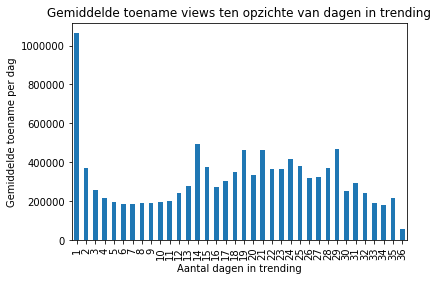

In [104]:
trending_UK.groupby("days_in_trending").increase_views.mean().plot(x="days_in_trending",y="increase_views",kind="bar",
                                                               title='Gemiddelde toename views ten opzichte van dagen in trending')
plt.xlabel('Aantal dagen in trending')
plt.ylabel('Gemiddelde toename per dag')
plt.plot()

## 7.  Wat zijn de meest voorkomende categorieën en hoe verschilt dat bij verschillende like/view ratio’s?

[]

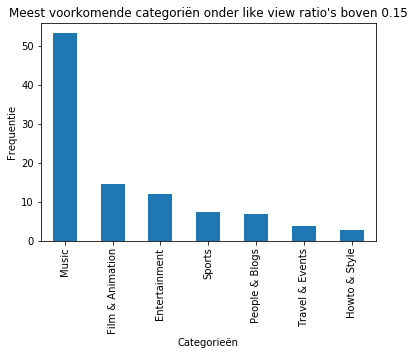

In [105]:
# Welke categorieën zijn sterk vertegenwoordigd bij de hoge ratio?
Representation=trending_UK[trending_UK.like_view_ratio > 0.15].category_name.value_counts()/len(trending_UK[trending_UK.like_view_ratio > 0.15])*100
Representation.plot(kind="bar", title="Meest voorkomende categoriën onder like view ratio's boven 0.15")
plt.xlabel('Categorieën')
plt.ylabel('Frequentie')
plt.plot()

## 8. Is er een verband tussen de uploaddatum en de datum dat een video trending wordt?

In [106]:
from datetime import date

def get_difference(publish_date, trending_date):
    """
    Calculates the difference in days between two given dates.
    """
    pub_strip = publish_date.split(".")
    tren_strip = trending_date.split(".")
    
    d1 = date(2000 + int(pub_strip[0]), int(pub_strip[2]), int(pub_strip[1]))
    d2 = date(2000 + int(tren_strip[0]), int(tren_strip[2]), int(tren_strip[1]))
    
    # return het verschil
    return abs((d2 - d1).days)

In [107]:
def add_difference(trending):
    """
    Helper function to add for every video the difference between, publish and trending date.
    """
    temp_dict={}
    for x in trending.index:
        try:
            temp_dict[x]= get_difference(trending.publish_date[x], trending.trending_date[x])
        except:
            temp_dict[x] = 0

        # Print progressie percentage
        if x % 1000 == 0:
            print((x / 23370) * 100, '%')
    trending["difference"]=pd.DataFrame.from_dict(temp_dict,orient="index")
    return trending

In [108]:
# Calculate the difference for all videos
new_trending = add_difference(trending_UK.drop_duplicates(subset='title'))

0.0 %
21.3949507916 %
25.6739409499 %
42.7899015832 %
81.3008130081 %


In [109]:
new_trending

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,category_name,like_view_ratio,dislike_view_ratio,like_dislike_ratio,timecode,publish_date,time_until_trending,increase_views,days_in_trending,difference
0,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,...,Howto & Style,0.007707,0.001418,5.433883,8,17.11.11,80,7224515,1,3
1,17.14.11,EXTREME GOLDEN TAN TRANSFORMATION,John Maclean,26,2017-11-10T20:40:44.000Z,"Extreme Tan|""Tanning""|""Tanning Bed""|""How to ge...",300617,8133,2693,2911,...,Howto & Style,0.027054,0.008958,3.020052,21,17.11.11,93,300617,1,3
2,17.14.11,How To Dry a Shirt in 30 Seconds,HowToBasic,26,2017-11-09T18:36:48.000Z,"how to dry a shirt in 30 seconds|""how to dry a...",2063667,98804,11682,11443,...,Howto & Style,0.047878,0.005661,8.457798,19,17.10.11,115,2063667,1,4
3,17.14.11,SO Much To Tell You | 32 Weeks Pregnant | MOTH...,Sprinkleofglitter,26,2017-11-10T16:59:50.000Z,"sprinkleofglitter|""sprinkle of glitter""|""Louis...",238843,10028,248,650,...,Howto & Style,0.041986,0.001038,40.435484,17,17.11.11,89,238843,1,3
4,17.14.11,GET READY WITH ME + LILY! (we're so immature bye),makeupbymichaelfinch,26,2017-11-09T22:00:00.000Z,"Lily brown|""michael finch""|""makeupbymichaelfin...",332967,22303,700,1523,...,Howto & Style,0.066983,0.002102,31.861429,22,17.10.11,118,332967,1,4
5,17.14.11,SECRETS REVEALED! HOW I LAY MY LACE WIGS! | AA...,MsAaliyahJay,26,2017-11-10T01:30:00.000Z,11-8-17,219030,14303,398,1099,...,Howto & Style,0.065302,0.001817,35.937186,2,17.11.11,74,219030,1,3
6,17.14.11,Three meals that cost me $1.50 each,Brothers Green Eats,26,2017-11-09T14:00:08.000Z,"brothers green eats|""budget cooking""|""cooking ...",77630,1991,83,208,...,Howto & Style,0.025647,0.001069,23.987952,14,17.10.11,110,77630,1,4
7,17.14.11,My Every Day Autumn Makeup | Zoella,Zoella,26,2017-11-08T18:24:16.000Z,"zoe sugg|""zoe""|""sugg""|""zoella""|""beauty""|""cosme...",1390440,86207,1775,710,...,Howto & Style,0.062000,0.001277,48.567324,19,17.9.11,139,1390440,1,5
8,17.14.11,Corey Haim's Mom Talks to Dr. Oz,DoctorOz,26,2017-11-10T15:02:20.000Z,"Dr. Oz|""Dr. Mehmet Oz""|""The Dr. Oz Show""|""Core...",42479,42,8,98,...,Howto & Style,0.000989,0.000188,5.250000,16,17.11.11,88,42479,1,3
9,17.14.11,Chocolate Orange Autumn Cupcakes | Cupcake Jemma,CupcakeJemma,26,2017-11-09T18:30:01.000Z,"cupcakes|""cupcake""|""cup cake""|""cake""|""cakes""|""...",122669,5723,55,263,...,Howto & Style,0.046654,0.000448,104.054545,19,17.10.11,115,122669,1,4


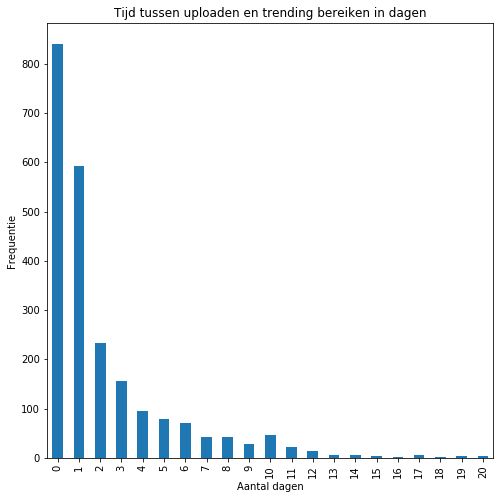

In [110]:
# Tel waardes en selecter de waardes die meer dan één keer voorkomen. Sorteer van 0 tot 20 dagen. 
new_trending.difference.value_counts().sort_index()[new_trending.difference.value_counts() > 1].plot(kind='bar', figsize=(8,8),
                                            title='Tijd tussen uploaden en trending bereiken in dagen')
# Voeg x en y label toe
plt.xlabel('Aantal dagen')
plt.ylabel('Frequentie')
plt.show()